# Tiled image file formats: zarr

When working with big image data, special file formats such as the [zarr](https://zarr.readthedocs.io/en/stable/) format are commonly used. Zarr stores image data in chunks. Instead of loading a huge image data set from disk and then tiling it, it is possible to load individual zarr tiles, process them and save the result back to disc. In that way one can process big images without ever loading the big image into memory. 

Using these formats brings additional challenges, for example re-saving the big image into small zarr-based tiles must happen on a computer that is capable of opening the big image to begin with. This notebook shows how to do this in a slightly unrealistic scenario: We're loading the dataset first to resave it as tiles and by the end, we load these tiles from disk and visualize them. In a realistic scenario, these two steps would not be possible. Depending on the scenario, those two steps must be improvised.

See also
* [Genevieve Buckley's gist: save_as_zarr.ipynb](https://gist.github.com/GenevieveBuckley/d94351adcc61cb5237a6c0a540c14cf6)
* [dask.array.from_zarr](https://docs.dask.org/en/stable/generated/dask.array.from_zarr.html#dask.array.from_zarr)


In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
from numcodecs import Blosc
import stackview

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed [License: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ) in mouse_brain.zip 

StackViewNDArray([[ 0,  0,  0, ...,  0,  0,  0],
                  [ 0,  0,  0, ...,  0,  0,  0],
                  [ 0,  0,  0, ...,  0,  0,  0],
                  ...,
                  [ 0,  0,  0, ...,  8,  5,  0],
                  [ 8,  1,  0, ..., 15,  9,  5],
                  [53, 23,  2, ..., 21, 10,  7]], dtype=uint8)
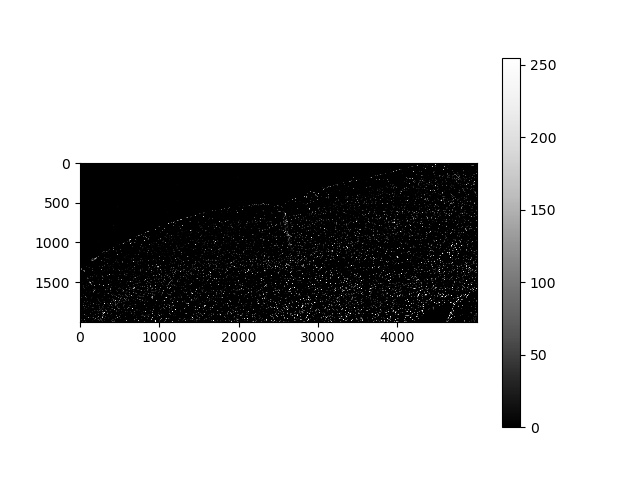
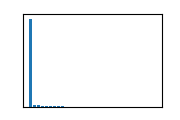

In [2]:
image = imread('data/P1_H_C3H_M004_17-cropped.tif')[1]
stackview.insight(image)

For testing purposes, we could crop the image even more. 

In [3]:
#image = image[1000:1500, 1000:1500]
#stackview.insight(image)

## Saving as zarr
We will now resaved our big image to the [zarr](https://zarr.readthedocs.io/en/stable/) file format. So that we can re-load it lazily.

In [4]:
#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

chunk_size = (100, 100)

zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

In [5]:
zarr_filename = 'data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

You will then see that a folder is created with the given name. In that folder many files will be located. Each of these files correspond to an image tile.

## Loading zarr
Just for demonstration purposes, we will load the zarr backed tiled image and visualize it. When working with big data, this step might not be possible.

In [6]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(2000, 5000), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

Yet, this image was not loaded. We need to call this function to get the actual pixels:

StackViewNDArray([[ 0,  0,  0, ...,  0,  0,  0],
                  [ 0,  0,  0, ...,  0,  0,  0],
                  [ 0,  0,  0, ...,  0,  0,  0],
                  ...,
                  [ 0,  0,  0, ...,  8,  5,  0],
                  [ 8,  1,  0, ..., 15,  9,  5],
                  [53, 23,  2, ..., 21, 10,  7]], dtype=uint8)
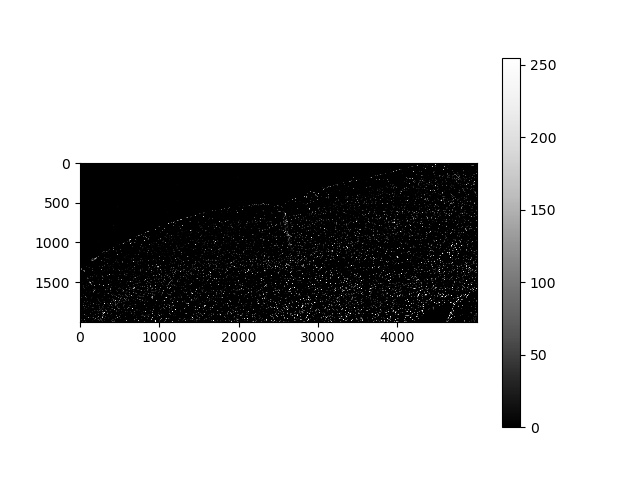
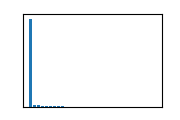

In [7]:
image = zarr_image.compute()

stackview.insight(image)